**Program:** Telecom Traffic CSV Data Generator

**Author:** Hirushiharan Thevendran

**Organization:** UoM Distributed Computing Concepts for AI module mini project

**Created On:** 06/21/2024

**Last modified By:** Hirushiharan

**Last Modified On:** 06/21/2024

**Program Description:** This script generates synthetic telecom traffic data using the Faker library. The data includes call records with
various details such as caller and callee information, tower locations, call start and end times, call duration,
and call type. The generated data is saved to a CSV file.

**Python Version:** 3.9-slim

In [228]:
# Install dependancies
!pip install faker

In [229]:
from faker import Faker

# Initialize Faker
fake = Faker()

# Define the number of rows of data to generate
num_rows = 100000

# Define lists for sample tower names and call types
call_types = ['Incoming', 'Outgoing']

In [230]:
from datetime import datetime, timedelta

def log(message, level="INFO"):
    """
    Log messages with a timestamp and a specific log level.

    Args:
        message (str): The message to log.
        level (str): The log level (e.g., INFO, WARN, ERROR).

    Returns:
        None
    """
    timestamp = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    print(f"{timestamp} [{level}] {message}")

In [231]:
import random
from datetime import timedelta
from faker import Faker

fake = Faker()

call_types = ['incoming', 'outgoing']

def generate_call_record():
    """
    Generate a single synthetic call record.

    Returns:
        dict: A dictionary containing the details of a call record.
    """
    call_id = random.randint(1000000, 9999999)
    caller_user_name = fake.user_name()
    callee_user_name = fake.user_name()
    caller_tower_name = fake.company()
    callee_tower_name = fake.company()
    call_start_date_time = fake.date_time_this_year()
    call_end_date_time = call_start_date_time + timedelta(seconds=random.randint(10, 3600))
    call_duration_seconds = int((call_end_date_time - call_start_date_time).total_seconds())
    call_type = random.choice(call_types)
    return {
        'CALL_ID': call_id,
        'CALLER_USER_NAME': caller_user_name,
        'CALLEE_USER_NAME': callee_user_name,
        'CALLER_TOWER_NAME': caller_tower_name,
        'CALLEE_TOWER_NAME': callee_tower_name,
        'CALL_START_DATE_TIME': call_start_date_time,
        'CALL_END_DATE_TIME': call_end_date_time,
        'CALL_DURATION': call_duration_seconds,
        'CALL_TYPE': call_type
    }

# Example usage
call_record = generate_call_record()
print(call_record)


{'CALL_ID': 3781368, 'CALLER_USER_NAME': 'williamsdan', 'CALLEE_USER_NAME': 'sarahlucas', 'CALLER_TOWER_NAME': 'Matthews Inc', 'CALLEE_TOWER_NAME': 'Allen, Lutz and Cross', 'CALL_START_DATE_TIME': datetime.datetime(2024, 6, 8, 16, 6, 51, 394254), 'CALL_END_DATE_TIME': datetime.datetime(2024, 6, 8, 16, 48, 24, 394254), 'CALL_DURATION': 2493, 'CALL_TYPE': 'incoming'}


In [232]:
import pandas as pd

def main():
    """
    Main function to generate synthetic telecom traffic data and save it to a CSV file.
    """
    try:
        # Generate the data
        log(f"Generating {num_rows} rows of synthetic telecom traffic data...")
        data = [generate_call_record() for _ in range(num_rows)]

        # Create a DataFrame
        df = pd.DataFrame(data)

        # Write the DataFrame to a CSV file
        csv_file_path = 'telecom_traffic_data.csv'
        df.to_csv(csv_file_path, index=False)

        log(f"Data generation complete. File saved as '{csv_file_path}'.")

    except Exception as e:
        log(f"An error occurred during data generation: {e}", level="ERROR")

if __name__ == "__main__":
    main()

2024-06-21 09:00:54 [INFO] Generating 100000 rows of synthetic telecom traffic data...
2024-06-21 09:02:41 [INFO] Data generation complete. File saved as 'telecom_traffic_data.csv'.


**Program:** Telecommunication Traffic Data Collection

**Author:** Hirushiharan Thevendran

**Organization:** UoM Distributed Computing Concepts for AI module mini project

**Created On:** 06/20/2024

**Last modified By:** Hirushiharan

**Last Modified On:** 06/21/2024

**Program Description:** A program to load data from a MySQL view into HDFS using Spark. This script connects to a MySQL database,
retrieves data from a specific view, and writes it into HDFS in Parquet format after processing the data after pre-processing the data.
This script performs the following preprocessing steps:

1. Remove null rows: Check for values values in each row and remove.
2. Calculate the Total Call Duration per User: Calculate the total call duration per user.
3. Find the busiest hour of the day based on call start and end times: Calculate the busiest hour based on Start date & time and End date & time.
4. Group Customers Based on Their Usage Patterns: Calculate the total call duration per user and categorize them as high-value or low-usage customers.
5. Aggregate Call Data by the Tower Location: Aggregate call data by the tower location, calculating the total call duration and the number of users per tower location.
6. Identify and Remove Duplicate Records: Identify and remove duplicate records from the dataset.

**Python Version:** 3.9-slim

In [233]:
# Install dependancies
!pip install pyspark
!apt install openjdk-8-jdk-headless &> /dev/null

In [234]:
from pyspark.sql import SparkSession

# Create and configure a Spark session.
spark = SparkSession.builder.appName("Preprocessing Telecom Data").getOrCreate()

In [235]:
filename = 'telecom_traffic_data.csv'

df = spark.read.csv(filename,header=True, inferSchema=True)
df.printSchema()
df.show(5, truncate=False)

root
 |-- CALL_ID: integer (nullable = true)
 |-- CALLER_USER_NAME: string (nullable = true)
 |-- CALLEE_USER_NAME: string (nullable = true)
 |-- CALLER_TOWER_NAME: string (nullable = true)
 |-- CALLEE_TOWER_NAME: string (nullable = true)
 |-- CALL_START_DATE_TIME: timestamp (nullable = true)
 |-- CALL_END_DATE_TIME: timestamp (nullable = true)
 |-- CALL_DURATION: integer (nullable = true)
 |-- CALL_TYPE: string (nullable = true)

+-------+----------------+----------------+--------------------------+------------------+--------------------------+--------------------------+-------------+---------+
|CALL_ID|CALLER_USER_NAME|CALLEE_USER_NAME|CALLER_TOWER_NAME         |CALLEE_TOWER_NAME |CALL_START_DATE_TIME      |CALL_END_DATE_TIME        |CALL_DURATION|CALL_TYPE|
+-------+----------------+----------------+--------------------------+------------------+--------------------------+--------------------------+-------------+---------+
|4921930|herreramorgan   |nknox           |Harmon-Ortega     

In [236]:
# Drop duplicate & null rows
df = df.dropDuplicates().dropna()

In [237]:
from pyspark.sql.functions import col, hour, concat, lit

# Extract the hour of the day from the combined timestamp column
df = df.withColumn("CALL_START_HOUR", hour("CALL_START_DATE_TIME"))
df = df.withColumn("CALL_END_HOUR", hour("CALL_END_DATE_TIME"))

# Combine the start and end hours
df = df.withColumn("CALL_HOUR", concat(col("CALL_START_HOUR"), lit("-"), col("CALL_END_HOUR")))

df.show(5, truncate=False)


+-------+----------------+----------------+-------------------------+------------------------+--------------------------+--------------------------+-------------+---------+---------------+-------------+---------+
|CALL_ID|CALLER_USER_NAME|CALLEE_USER_NAME|CALLER_TOWER_NAME        |CALLEE_TOWER_NAME       |CALL_START_DATE_TIME      |CALL_END_DATE_TIME        |CALL_DURATION|CALL_TYPE|CALL_START_HOUR|CALL_END_HOUR|CALL_HOUR|
+-------+----------------+----------------+-------------------------+------------------------+--------------------------+--------------------------+-------------+---------+---------------+-------------+---------+
|1041926|iwalker         |oscarcosta      |Smith Ltd                |Lane, Neal and Reeves   |2024-01-12 18:48:54.522251|2024-01-12 19:29:08.522251|2414         |outgoing |18             |19           |18-19    |
|6404903|anthony67       |chavezbrenda    |Howard, Carter and Watson|Shaw, Douglas and Campos|2024-02-17 05:48:05.274121|2024-02-17 06:24:08.274121|

In [238]:
from pyspark.sql.functions import col, unix_timestamp

# Filter out any rows where the calculated call duration is negative (data error handling)
filtered_call_duration = df.filter(df["CALL_DURATION"] >= 0)

# Group the data by user and sum the call durations for each user
call_duration_per_user = filtered_call_duration.groupBy("CALLER_USER_NAME").agg({"CALL_DURATION": "sum"}).withColumnRenamed("sum(CALL_DURATION)", "TOTAL_CALL_DURATION")

call_duration_per_user.show()


+-----------------+-------------------+
| CALLER_USER_NAME|TOTAL_CALL_DURATION|
+-----------------+-------------------+
|     cherylwilson|               2102|
|    rollinsdustin|               3280|
|          ymiller|              26896|
|     mendozaaaron|               1086|
|         cmcgrath|               3427|
|       ayalacarly|               2141|
|      calebmiller|               3151|
|         mariah30|               1876|
|      jonesjustin|               4357|
|         kristy47|                666|
|        clarkjoel|                359|
|  carolyndelacruz|               2840|
|           hcasey|               3040|
|          rmiller|              32468|
|     crystalbaker|               1809|
|        dunndaisy|               1164|
|         johnny88|               2817|
|fitzpatrickjoseph|               2653|
|          kevin74|               1300|
|          pmalone|               2355|
+-----------------+-------------------+
only showing top 20 rows



In [239]:
# Group the data by hour and calculate both the total call count and total call duration
busiest_hour_df = filtered_call_duration.groupBy("CALL_HOUR").agg(
    count("*").alias("TOTAL_CALL_COUNT"),
    Fsum("CALL_DURATION").alias("TOTAL_CALL_DURATION")
).orderBy(col("CALL_HOUR").asc())

busiest_hour_df.show(truncate=False)

+---------+----------------+-------------------+
|CALL_HOUR|TOTAL_CALL_COUNT|TOTAL_CALL_DURATION|
+---------+----------------+-------------------+
|0-0      |2080            |2541859            |
|0-1      |2077            |5003480            |
|1-1      |2156            |2610854            |
|1-2      |2075            |4999885            |
|10-10    |2119            |2529403            |
|10-11    |2123            |5056406            |
|11-11    |2109            |2480769            |
|11-12    |2045            |4945727            |
|12-12    |2090            |2519007            |
|12-13    |2123            |5104676            |
|13-13    |2066            |2443519            |
|13-14    |2059            |4921034            |
|14-14    |2111            |2596881            |
|14-15    |2091            |4950116            |
|15-15    |2082            |2594338            |
|15-16    |1987            |4819971            |
|16-16    |2097            |2604145            |
|16-17    |2050     

In [240]:
from pyspark.sql.window import Window
from pyspark.sql.functions import desc, row_number, rank

# Define window specification with partition by 'CALLER_USER_NAME' and order by descending total call duration
window_spec = Window.partitionBy("CALLER_USER_NAME").orderBy(desc("TOTAL_CALL_DURATION"))

# Rank users based on their total call duration
call_duration_per_user = call_duration_per_user.withColumn("RANK", rank().over(window_spec))

# Filter to identify high-value and low-usage customers
high_value_users = call_duration_per_user.filter(col("RANK") <= lit(100))  # Assuming top 100 users are high-value customers
low_usage_users = call_duration_per_user.filter(col("RANK") > lit(100))    # Remaining users are low-usage customers

high_value_users.show()
low_usage_users.show()

+----------------+-------------------+----+
|CALLER_USER_NAME|TOTAL_CALL_DURATION|RANK|
+----------------+-------------------+----+
|        aacevedo|                660|   1|
|         aacosta|               3472|   1|
|          aadams|               2647|   1|
|         aadkins|               3089|   1|
|        aaguilar|               1678|   1|
|        aaguirre|                147|   1|
|      aalexander|                758|   1|
|            aali|               1108|   1|
|          aallen|              12178|   1|
|       aalvarado|               3585|   1|
|        aalvarez|               4262|   1|
|       aanderson|              11804|   1|
|        aandrade|                123|   1|
|        aandrews|               1246|   1|
|          aarias|               3574|   1|
|         aarnold|               3530|   1|
|         aaron04|               1619|   1|
|         aaron06|               1641|   1|
|         aaron08|               3369|   1|
|         aaron09|              

In [241]:
# Group the data by tower location and aggregate call durations and user counts
call_data_by_location = filtered_call_duration.groupBy("CALLER_TOWER_NAME").agg({"CALL_DURATION": "sum", "CALLER_USER_NAME": "count"}
).withColumnRenamed("sum(CALL_DURATION)", "TOTAL_CALL_DURATION") \
 .withColumnRenamed("count(CALLER_USER_NAME)", "TOTAL_USERS")

call_data_by_location.show()


+--------------------+-------------------+-----------+
|   CALLER_TOWER_NAME|TOTAL_CALL_DURATION|TOTAL_USERS|
+--------------------+-------------------+-----------+
|       Collins-Lopez|               1691|          1|
|Romero, Kelley an...|               3336|          1|
|      White-Williams|               5545|          3|
|         Brown-James|               3386|          1|
|Schwartz, Anderso...|               1570|          1|
|Long, Wallace and...|               3427|          1|
|           Smith PLC|             210121|        117|
|Lowery, Meyers an...|                485|          1|
|            Soto PLC|               8316|          5|
|      Aguirre-Knight|                259|          1|
|          Hall Group|              60317|         36|
|Curtis, Jones and...|               1023|          1|
|     Odonnell-Burton|               1982|          1|
|       Smith-Burnett|               6370|          3|
|Reeves, Cook and ...|                435|          1|
|Alexander

In [242]:
def write_data_to_hdfs(df, output_path):
    """
    Write Spark DataFrame to HDFS in Parquet format.

    Args:
        df (DataFrame): Spark DataFrame to write.
        output_path (str): Output path in HDFS.

    Returns:
        None
    """
    print(f"Writing data to HDFS: {output_path}")
    df.write \
        .mode("overwrite") \
        .parquet(output_path)
    print(f"Data successfully written to HDFS: {output_path}")

In [243]:
hadoop_path = "/user/hadoop/telecom_data/"
hadoop_files = ["processed_data", "busiest_hour", "high_value_users", "low_usage_users", "call_data_by_tower", "call_duration_per_user"]

# Write DataFrames to HDFS in Parquet format
write_data_to_hdfs(df, f"{hadoop_path}{hadoop_files[0]}")
write_data_to_hdfs(busiest_hour_df, f"{hadoop_path}{hadoop_files[1]}")
write_data_to_hdfs(high_value_users, f"{hadoop_path}{hadoop_files[2]}")
write_data_to_hdfs(low_usage_users, f"{hadoop_path}{hadoop_files[3]}")
write_data_to_hdfs(call_data_by_location, f"{hadoop_path}{hadoop_files[4]}")
write_data_to_hdfs(call_duration_per_user, f"{hadoop_path}{hadoop_files[5]}")

Writing data to HDFS: /user/hadoop/telecom_data/processed_data
Data successfully written to HDFS: /user/hadoop/telecom_data/processed_data
Writing data to HDFS: /user/hadoop/telecom_data/busiest_hour
Data successfully written to HDFS: /user/hadoop/telecom_data/busiest_hour
Writing data to HDFS: /user/hadoop/telecom_data/high_value_users
Data successfully written to HDFS: /user/hadoop/telecom_data/high_value_users
Writing data to HDFS: /user/hadoop/telecom_data/low_usage_users
Data successfully written to HDFS: /user/hadoop/telecom_data/low_usage_users
Writing data to HDFS: /user/hadoop/telecom_data/call_data_by_tower
Data successfully written to HDFS: /user/hadoop/telecom_data/call_data_by_tower
Writing data to HDFS: /user/hadoop/telecom_data/call_duration_per_user
Data successfully written to HDFS: /user/hadoop/telecom_data/call_duration_per_user


**Program:** Telecommunication Traffic Data Collection

**Author:** Hirushiharan Thevendran

**Organization:** UoM Distributed Computing Concepts for AI module mini project

**Created On:** 06/21/2024

**Last modified By:** Hirushiharan

**Last Modified On:** 06/21/2024

Program Description: A program to perform data analysis on telecommunication traffic data. This script reads processed data
from HDFS in Parquet format and conducts various analyses including descriptive statistics, user-based aggregations,
tower-based aggregations, hourly call analysis, and trend analysis.

**Python Version:** 3.9-slim

In [244]:
# Install dependancies
!pip install matplotlib seaborn

In [245]:
import matplotlib.pyplot as plt
import seaborn as sns

def create_visualization(df, x_col, y_col, plot_type="bar", title="", xlabel="", ylabel="", top_n=None, xticks_rotation=0):
    """
    Create a dynamic visualization based on the provided parameters.

    Args:
        df (DataFrame): Input DataFrame.
        x_col (str): Column name for x-axis.
        y_col (str): Column name for y-axis.
        plot_type (str): Type of plot (e.g., "bar", "line", "hist").
        title (str): Title of the plot.
        xlabel (str): Label for x-axis.
        ylabel (str): Label for y-axis.
        top_n (int, optional): Number of top records to display (for bar plots).
        xticks_rotation (int, optional): Rotation angle for x-ticks.

    Returns:
        None
    """
    pd_df = df.toPandas()

    if top_n:
        pd_df = pd_df.head(top_n)

    plt.figure(figsize=(12, 8))

    if plot_type == "bar":
        sns.barplot(x=x_col, y=y_col, data=pd_df)
    elif plot_type == "line":
        sns.lineplot(x=x_col, y=y_col, data=pd_df, marker="o")
    elif plot_type == "hist":
        sns.histplot(pd_df[x_col], bins=30, kde=True)

    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xticks(rotation=xticks_rotation)
    plt.show()

In [246]:
# create Spark session

spark = SparkSession.builder.appName("Analysis").getOrCreate()

Total Call Duration per User Data:
Mean call duration: 2501.287836505755
Standard deviation of call duration: 2415.8292508168815
Variance of call duration: 5836230.969102456
Median call duration: 2135.0


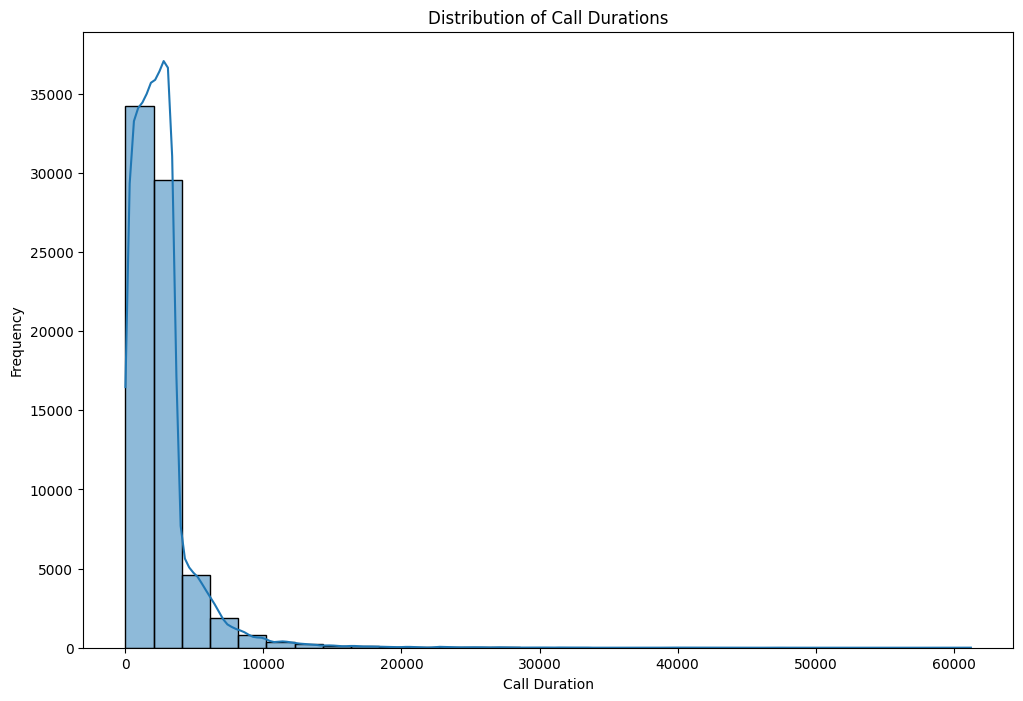

In [247]:
from pyspark.sql.functions import mean, stddev, variance

"""
Calculate and display descriptive statistics for total call duration.

Args:
    df (DataFrame): Input DataFrame.

Returns:
    None
"""

df = spark.read.parquet(f"{hadoop_path}{hadoop_files[5]}")
print("Total Call Duration per User Data:")

stats = df.select(
    mean("TOTAL_CALL_DURATION").alias("MEAN_DURATION"),
    stddev("TOTAL_CALL_DURATION").alias("STDDEV_DURATION"),
    variance("TOTAL_CALL_DURATION").alias("VARIANCE_DURATION")
).first()

quantiles = df.approxQuantile("TOTAL_CALL_DURATION", [0.5], 0.01)

print(f"Mean call duration: {stats['MEAN_DURATION']}")
print(f"Standard deviation of call duration: {stats['STDDEV_DURATION']}")
print(f"Variance of call duration: {stats['VARIANCE_DURATION']}")
print(f"Median call duration: {quantiles[0]}")

# Visualization
create_visualization(df, x_col="TOTAL_CALL_DURATION", y_col=None, plot_type="hist", title="Distribution of Call Durations", xlabel="Call Duration", ylabel="Frequency")

+----------------+-------------------+-----------------+-----------+
|CALLER_USER_NAME|TOTAL_CALL_DURATION|AVG_CALL_DURATION|TOTAL_CALLS|
+----------------+-------------------+-----------------+-----------+
|aarongibson     |1293               |1293.0           |1          |
|adam08          |7070               |7070.0           |1          |
|adam32          |2083               |2083.0           |1          |
|adam51          |4668               |4668.0           |1          |
|alexanderjenny  |690                |690.0            |1          |
|alexanderjohn   |2707               |2707.0           |1          |
|alexisnelson    |2027               |2027.0           |1          |
|allison98       |3545               |3545.0           |1          |
|amandawilliams  |518                |518.0            |1          |
|amy19           |4409               |4409.0           |1          |
|amyellis        |1977               |1977.0           |1          |
|amyreed         |252             

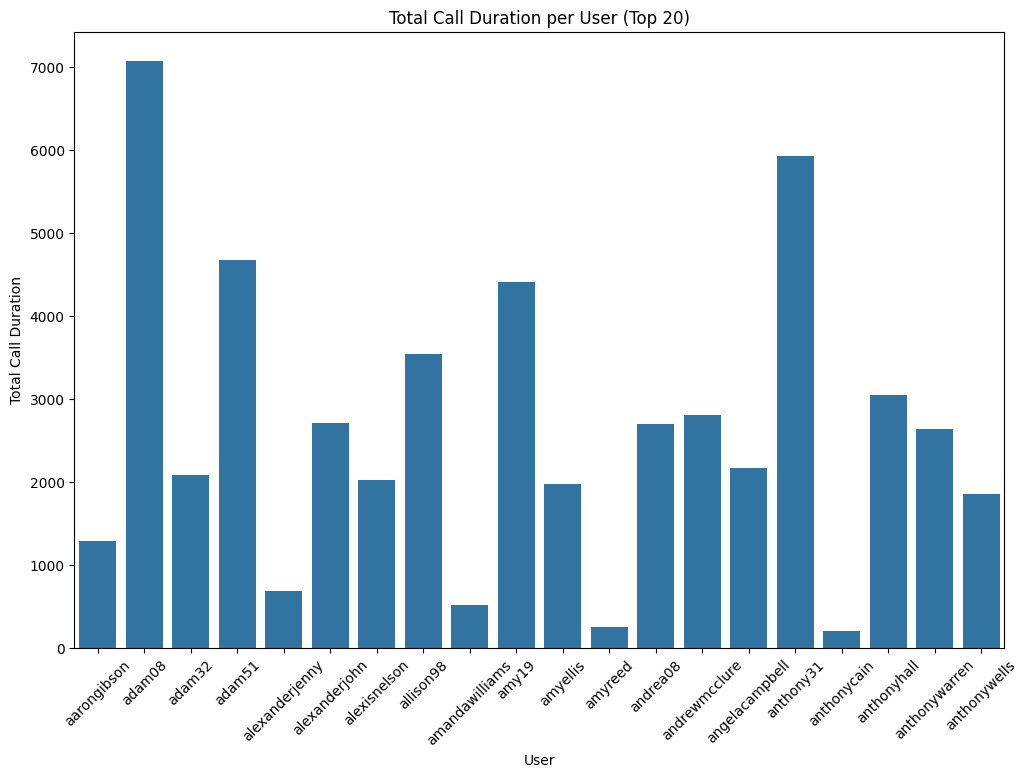

In [248]:
from pyspark.sql.functions import avg, count, sum as Fsum

"""
Perform user-based aggregations and visualize the results.

Args:
    df (DataFrame): Input DataFrame.

Returns:
    None
"""
user_stats = df.groupBy("CALLER_USER_NAME").agg(
    Fsum("TOTAL_CALL_DURATION").alias("TOTAL_CALL_DURATION"),
    avg("TOTAL_CALL_DURATION").alias("AVG_CALL_DURATION"),
    count("TOTAL_CALL_DURATION").alias("TOTAL_CALLS")
)
user_stats.show(truncate=False)

# Visualization
create_visualization(user_stats, x_col="CALLER_USER_NAME", y_col="TOTAL_CALL_DURATION", plot_type="bar", title="Total Call Duration per User (Top 20)", xlabel="User", ylabel="Total Call Duration", top_n=20, xticks_rotation=45)

+-------------------------+-------------------+-----------+
|CALLER_TOWER_NAME        |TOTAL_CALL_DURATION|TOTAL_USERS|
+-------------------------+-------------------+-----------+
|Benjamin and Sons        |6845               |1          |
|Miller Inc               |78181              |1          |
|Spencer-Garcia           |2363               |1          |
|Le Group                 |15684              |1          |
|Perez, Morris and Jones  |2874               |1          |
|Graham-Matthews          |2187               |1          |
|Arnold-Morgan            |1508               |1          |
|Wood-Johnson             |3511               |1          |
|Ramos-Davis              |6492               |1          |
|Cooper-Howard            |740                |1          |
|Stevens Inc              |16794              |1          |
|Ramsey Inc               |8717               |1          |
|Torres-Hickman           |154                |1          |
|Henderson PLC            |15524        

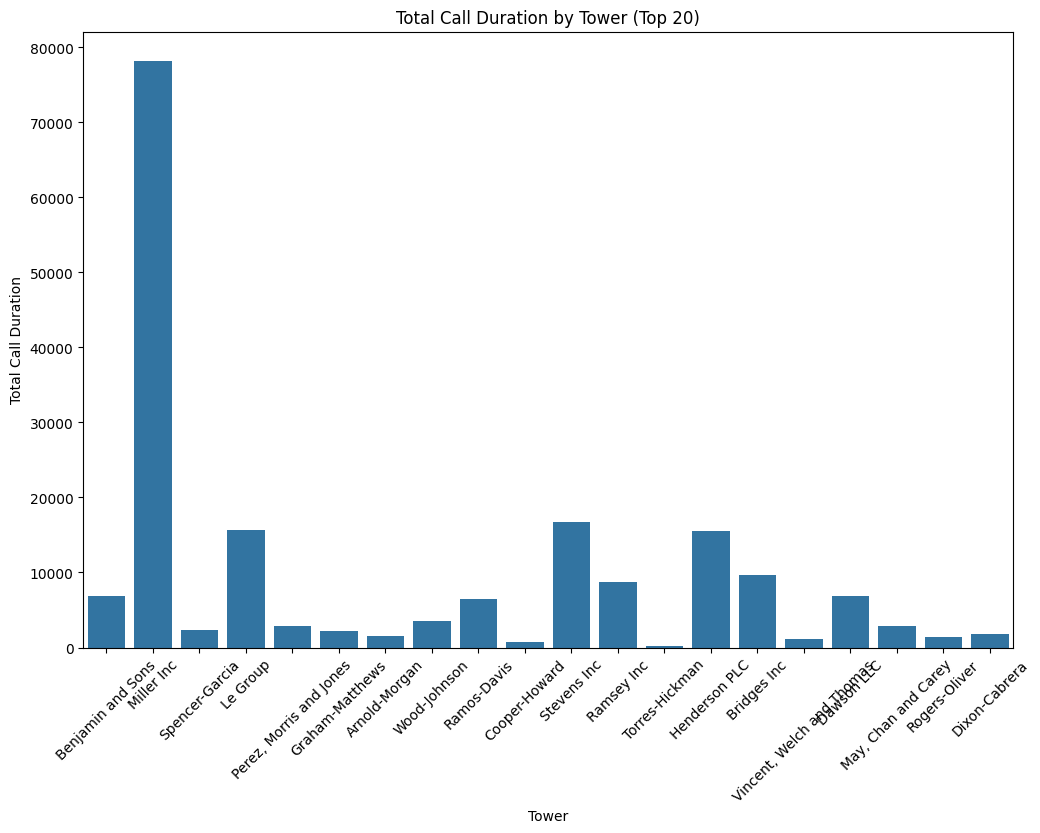

In [249]:
"""
Perform tower-based aggregations and visualize the results.

Args:
    df (DataFrame): Input DataFrame.

Returns:
    None
"""
df = spark.read.parquet(f"{hadoop_path}{hadoop_files[4]}")
tower_stats = df.groupBy("CALLER_TOWER_NAME").agg(
    Fsum("TOTAL_CALL_DURATION").alias("TOTAL_CALL_DURATION"),
    count("CALLER_TOWER_NAME").alias("TOTAL_USERS")
)
tower_stats.show(truncate=False)

# Visualization
create_visualization(tower_stats, x_col="CALLER_TOWER_NAME", y_col="TOTAL_CALL_DURATION", plot_type="bar", title="Total Call Duration by Tower (Top 20)", xlabel="Tower", ylabel="Total Call Duration", top_n=20, xticks_rotation=45)

Busiest Hour Data:
+---------+-------------------+----------------+
|CALL_HOUR|TOTAL_CALL_DURATION|TOTAL_CALL_COUNT|
+---------+-------------------+----------------+
|0-0      |2541859            |2080            |
|0-1      |5003480            |2077            |
|1-1      |2610854            |2156            |
|1-2      |4999885            |2075            |
|10-10    |2529403            |2119            |
|10-11    |5056406            |2123            |
|11-11    |2480769            |2109            |
|11-12    |4945727            |2045            |
|12-12    |2519007            |2090            |
|12-13    |5104676            |2123            |
|13-13    |2443519            |2066            |
|13-14    |4921034            |2059            |
|14-14    |2596881            |2111            |
|14-15    |4950116            |2091            |
|15-15    |2594338            |2082            |
|15-16    |4819971            |1987            |
|16-16    |2604145            |2097            |
|

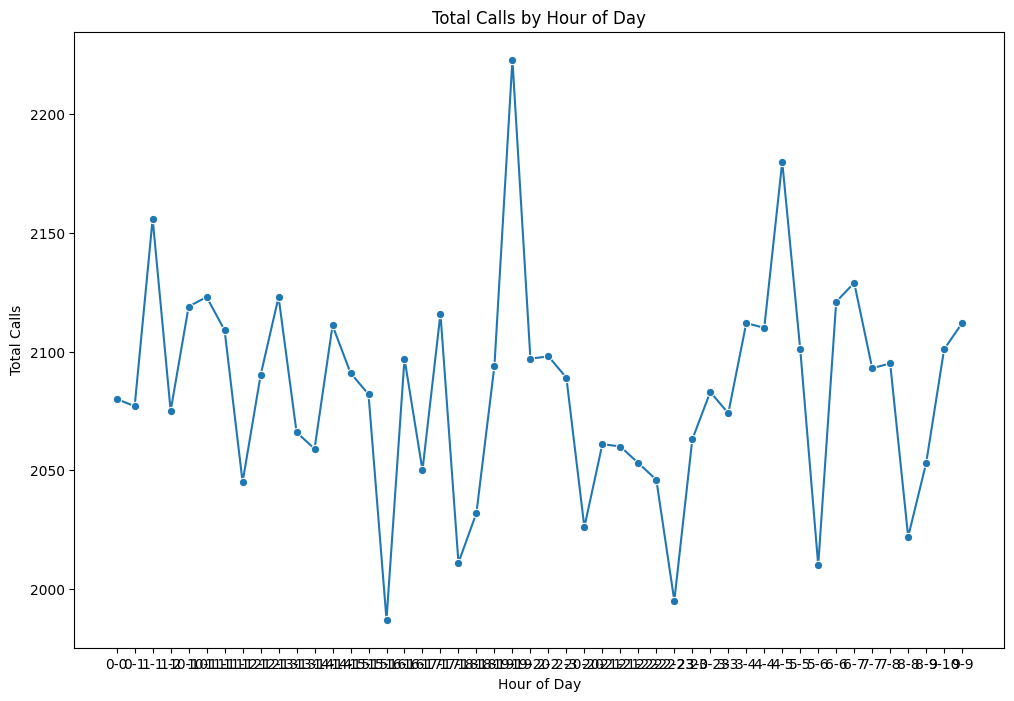

In [250]:
from pyspark.sql.functions import hour
"""
Perform hourly call analysis and visualize the results.

Args:
    df (DataFrame): Input DataFrame.

Returns:
    None
"""

df = spark.read.parquet(f"{hadoop_path}{hadoop_files[1]}")
print("Busiest Hour Data:")
hourly_stats = df.groupBy("CALL_HOUR").agg(
    Fsum("TOTAL_CALL_DURATION").alias("TOTAL_CALL_DURATION"),
    Fsum("TOTAL_CALL_COUNT").alias("TOTAL_CALL_COUNT")
).orderBy(col("CALL_HOUR").asc())
hourly_stats.show(truncate=False)

# Visualization
create_visualization(hourly_stats, x_col="CALL_HOUR", y_col="TOTAL_CALL_COUNT", plot_type="line", title="Total Calls by Hour of Day", xlabel="Hour of Day", ylabel="Total Calls", xticks_rotation=0)


+----------+-----------+-------------------+
|CALL_DATE |TOTAL_CALLS|TOTAL_CALL_DURATION|
+----------+-----------+-------------------+
|2024-01-01|587        |1041983            |
|2024-01-02|558        |995013             |
|2024-01-03|559        |1008982            |
|2024-01-04|553        |1041093            |
|2024-01-05|579        |1022216            |
|2024-01-06|555        |992261             |
|2024-01-07|593        |1048130            |
|2024-01-08|589        |1045163            |
|2024-01-09|567        |1027615            |
|2024-01-10|608        |1120879            |
|2024-01-11|578        |1054296            |
|2024-01-12|561        |1077844            |
|2024-01-13|578        |1004821            |
|2024-01-14|567        |1004092            |
|2024-01-15|551        |1014228            |
|2024-01-16|567        |1008660            |
|2024-01-17|573        |1023994            |
|2024-01-18|583        |1016115            |
|2024-01-19|595        |1060260            |
|2024-01-2

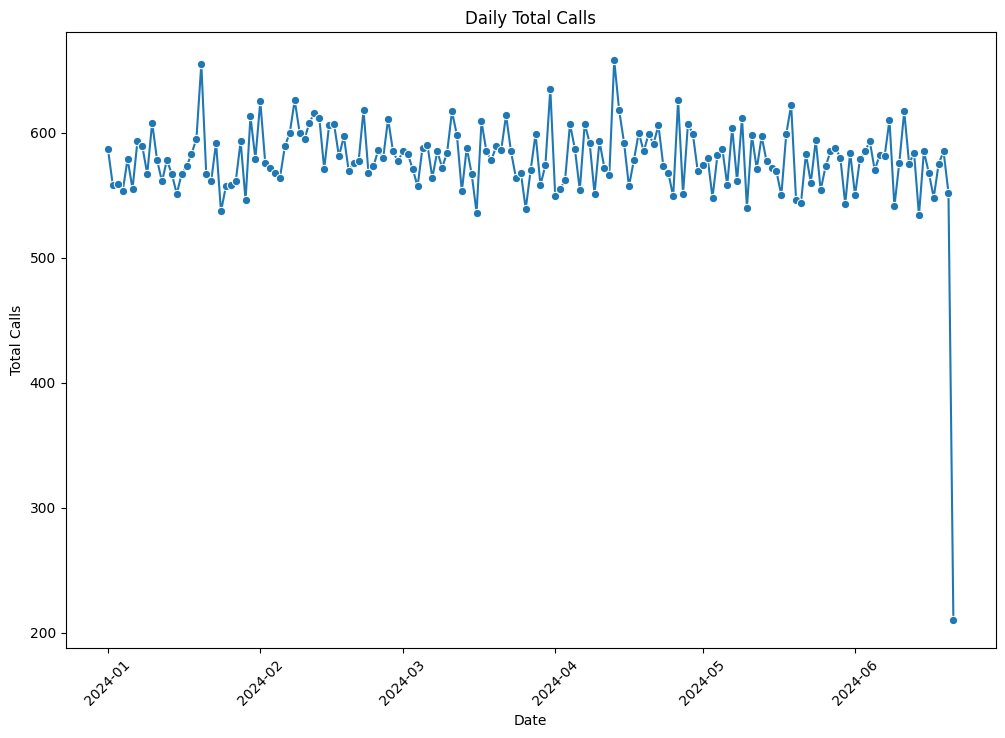

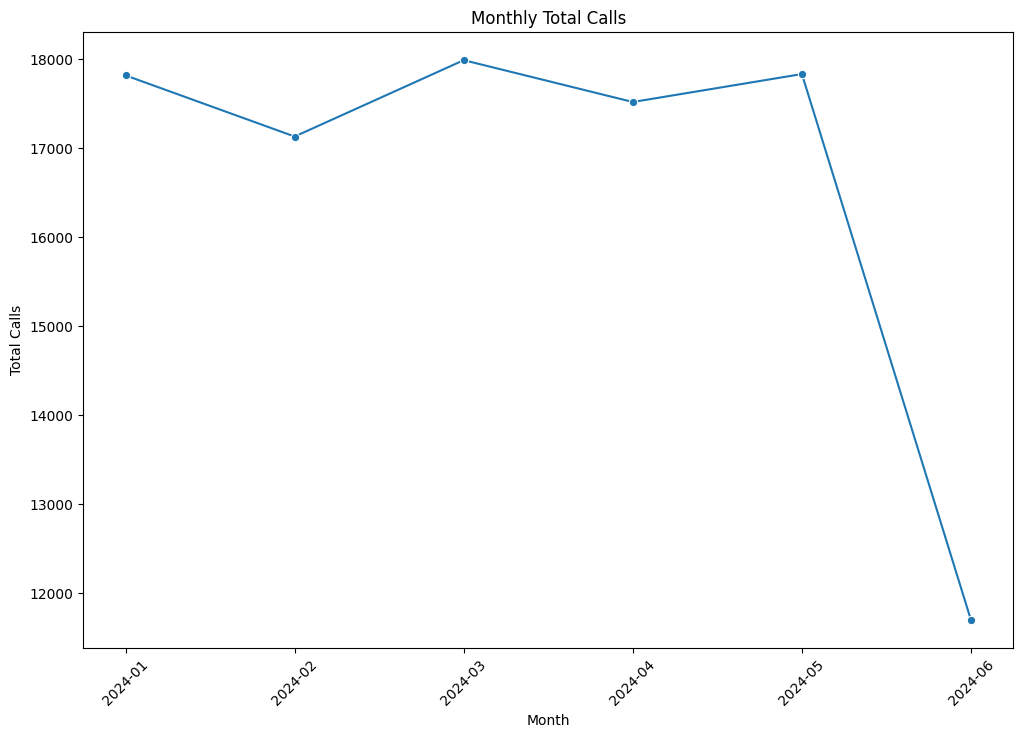

In [251]:
from pyspark.sql.functions import to_date, date_format

"""
Perform trend analysis on daily and monthly call data and visualize the results.

Args:
df (DataFrame): Input DataFrame.

Returns:
None
"""


df = spark.read.parquet(f"{hadoop_path}{hadoop_files[0]}")

daily_trends = df.withColumn("CALL_DATE", to_date("CALL_START_DATE_TIME")).groupBy("CALL_DATE").agg(
count("CALL_DURATION").alias("TOTAL_CALLS"),
Fsum("CALL_DURATION").alias("TOTAL_CALL_DURATION")
)

monthly_trends = df.withColumn("CALL_MONTH", date_format("CALL_START_DATE_TIME", "yyyy-MM")).groupBy("CALL_MONTH").agg(
count("CALL_DURATION").alias("TOTAL_CALLS"),
Fsum("CALL_DURATION").alias("TOTAL_CALL_DURATION")
)

daily_trends.orderBy("CALL_DATE").show(truncate=False)
monthly_trends.orderBy("CALL_MONTH").show(truncate=False)

# Visualization
create_visualization(daily_trends.orderBy("CALL_DATE"), x_col="CALL_DATE", y_col="TOTAL_CALLS", plot_type="line", title="Daily Total Calls", xlabel="Date", ylabel="Total Calls", xticks_rotation=45)
create_visualization(monthly_trends.orderBy("CALL_MONTH"), x_col="CALL_MONTH", y_col="TOTAL_CALLS", plot_type="line", title="Monthly Total Calls", xlabel="Month", ylabel="Total Calls", xticks_rotation=45)

In [252]:
"""
Load and display data for the busiest hour.

Args:
    spark (SparkSession): Spark session.

Returns:
    None
"""
df = spark.read.parquet(f"{hadoop_path}{hadoop_files[1]}")
print("Busiest Hour Data:")
df.show(truncate=False)

Busiest Hour Data:
+---------+----------------+-------------------+
|CALL_HOUR|TOTAL_CALL_COUNT|TOTAL_CALL_DURATION|
+---------+----------------+-------------------+
|0-0      |2080            |2541859            |
|0-1      |2077            |5003480            |
|1-1      |2156            |2610854            |
|1-2      |2075            |4999885            |
|10-10    |2119            |2529403            |
|10-11    |2123            |5056406            |
|11-11    |2109            |2480769            |
|11-12    |2045            |4945727            |
|12-12    |2090            |2519007            |
|12-13    |2123            |5104676            |
|13-13    |2066            |2443519            |
|13-14    |2059            |4921034            |
|14-14    |2111            |2596881            |
|14-15    |2091            |4950116            |
|15-15    |2082            |2594338            |
|15-16    |1987            |4819971            |
|16-16    |2097            |2604145            |
|

In [253]:
df = spark.read.parquet(f"{hadoop_path}{hadoop_files[2]}")
print("High Value Users Data:")
df.show(truncate=False)

High Value Users Data:
+----------------+-------------------+----+
|CALLER_USER_NAME|TOTAL_CALL_DURATION|RANK|
+----------------+-------------------+----+
|aacevedo        |660                |1   |
|aacosta         |3472               |1   |
|aadams          |2647               |1   |
|aadkins         |3089               |1   |
|aaguilar        |1678               |1   |
|aaguirre        |147                |1   |
|aalexander      |758                |1   |
|aali            |1108               |1   |
|aallen          |12178              |1   |
|aalvarado       |3585               |1   |
|aalvarez        |4262               |1   |
|aanderson       |11804              |1   |
|aandrade        |123                |1   |
|aandrews        |1246               |1   |
|aarias          |3574               |1   |
|aarnold         |3530               |1   |
|aaron04         |1619               |1   |
|aaron06         |1641               |1   |
|aaron08         |3369               |1   |
|aaron09 

In [254]:
df = spark.read.parquet(f"{hadoop_path}{hadoop_files[3]}")
print("Low Usage Users Data:")
df.show(truncate=False)

Low Usage Users Data:
+----------------+-------------------+----+
|CALLER_USER_NAME|TOTAL_CALL_DURATION|RANK|
+----------------+-------------------+----+
+----------------+-------------------+----+

